# Lecture 5 - Data-Driven Analysis Using DynamicalSystems.jl

- Last week we saw how to model a dynamical system with a known dynamic rule using DynamicalSystems.jl. We also saw how to calculate various dynamical properties of such a system, for example, Lyapunov exponents.
<br>

- This week we will turn our attention to data-driven analysis using DynamicalSystems.jl. In other words, **we suppose that we observe some system without necessarily knowing the dynamic rule in advance**.
<br>

- More often than not, what we observe in real life isn't the entire phase space, in which the dynamics unfold, but rather some projection of the state onto a lower-dimensional space. That is why our discussion of data-driven algorithms will focus in particular on phase space reconstruction using coordinate embedding, as you saw in this part of the lecture.


## Contents

1. [Delay Coordinates Embedding](#embedding)
2. [Choosing the Optimal Delay Time](#time)
3. [Choosing the Optimal Embedding Dimension](#dimension)
4. [Putting It All Together](#together)
5. [Lyapunov Exponents](#lyapunov)
6. [Forecasts with Time Delay Embedding](#forecasts)
7. [Further Reading](#further-reading)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(["DynamicalSystems", "NearestNeighbors", "CairoMakie"])

  Activating project at `~/code/TUM-Dynamics-Lecture/lectures/lecture-5`
   Resolving package versions...
  No Changes to `~/code/TUM-Dynamics-Lecture/lectures/lecture-5/Project.toml`
  No Changes to `~/code/TUM-Dynamics-Lecture/lectures/lecture-5/Manifest.toml`


In [2]:
using DynamicalSystems, NearestNeighbors, CairoMakie

## 1. Delay Coordinates Embedding <a class="anchor" id="embedding"></a>

- Recall from the first part of the lecture that a scalar timeseries $s(t)$ can be embedded in a space of dimension $m$ via a delay embedding of the form $(s(t), s(t - \tau), s(t - 2\tau), \ldots, s(t - (m-1)\tau))$.
<br>

- To demonstrate delay embedding using DynamicalSystems.jl, we will "observe" the Lorenz system with a scalar measurement function $h : \mathbb{R}^3 \to \mathbb{R}$, such that our observation consists of a one-dimensional timeseries $s(t) = h(\mathbf{u}(t))$.
<br>

- For simplicity, we will take $s(t) = h(\mathbf{u}(t)) = x(t)$, that is, we observe only the $x$-coordinate. If the three dimensions of the Lorenz system correspond roughly to the rate of convection and the horizontal and vertical temperature variations, respectively, then this is like saying that we observe only the rate of convection.

In [3]:
h(u) = u[:, 1]  # Measurement function

h (generic function with 1 method)

In [4]:
# Generate synthetic data
ds = Systems.lorenz()
T = 100.0
Δt = 0.01
u = trajectory(ds, T; Ttr = 100.0, Δt)[1]

3-dimensional StateSpaceSet{Float64} with 10001 points
  -7.9554     -14.5316    12.6248
  -8.63368    -15.6189    13.5269
  -9.35128    -16.7105    14.606
 -10.1036     -17.7795    15.878
 -10.8836     -18.7918    17.3552
 -11.6814     -19.7057    19.0436
 -12.4835     -20.4731    20.9405
 -13.273      -21.0405    23.031
 -14.0296     -21.3532    25.2849
 -14.7294     -21.359     27.6553
 -15.3466     -21.0154    30.0779
 -15.8543     -20.2953    32.4728
 -16.2266     -19.1938    34.7504
   ⋮                      
   0.64355     -0.540919  20.9436
   0.533206    -0.492747  20.3895
   0.437688    -0.449913  19.8507
   0.355079    -0.412381  19.3267
   0.283651    -0.380013  18.8169
   0.221859    -0.352609  18.3208
   0.168325    -0.329928  17.838
   0.121825    -0.311713  17.3682
   0.0812788   -0.297704  16.9109
   0.0457303   -0.287653  16.4657
   0.0143394   -0.281329  16.0323
  -0.0136347   -0.278531  15.6104

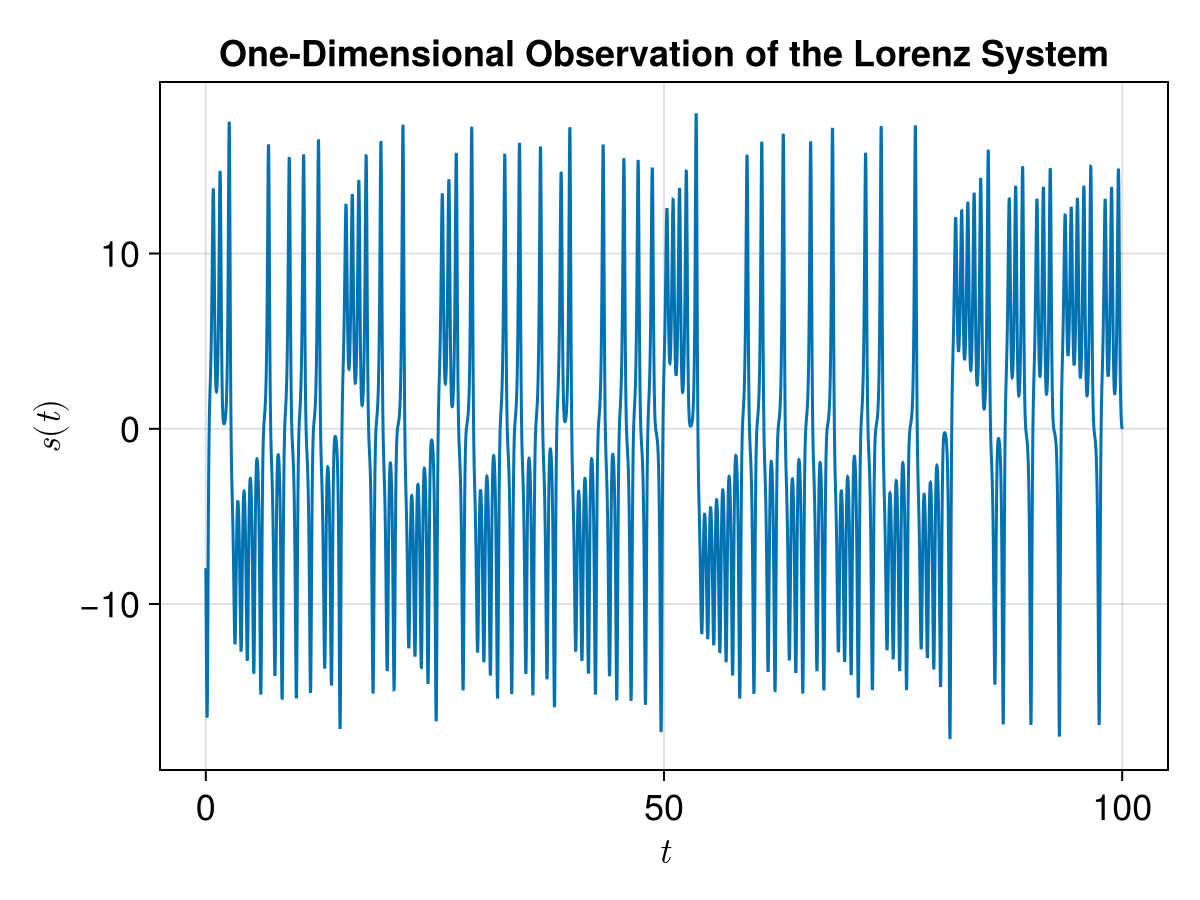

In [5]:
# "Measure" s(t) = h(u(t)) = x(t)
s = h(u)
fig = Figure(fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"t", ylabel = L"s(t)", title = "One-Dimensional Observation of the Lorenz System")
lines!(ax, 0:Δt:T, s)
fig

- To embed a one-dimensional timeseries $s(t)$ with embedding dimension $d$ and delay time $\tau \Delta t$, just do `embed(s, d, τ)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/embed/#DelayEmbeddings.embed)).

In [6]:
d = 3
τ = 4
embed(s, d, τ)

3-dimensional StateSpaceSet{Float64} with 9993 points
  -7.9554    -10.8836    -14.0296
  -8.63368   -11.6814    -14.7294
  -9.35128   -12.4835    -15.3466
 -10.1036    -13.273     -15.8543
 -10.8836    -14.0296    -16.2266
 -11.6814    -14.7294    -16.441
 -12.4835    -15.3466    -16.4803
 -13.273     -15.8543    -16.3352
 -14.0296    -16.2266    -16.0046
 -14.7294    -16.441     -15.4969
 -15.3466    -16.4803    -14.8288
 -15.8543    -16.3352    -14.0235
 -16.2266    -16.0046    -13.1091
   ⋮                     
   2.35408     1.27854     0.64355
   2.03339     1.08572     0.533206
   1.74931     0.91739     0.437688
   1.49874     0.770839    0.355079
   1.27854     0.64355     0.283651
   1.08572     0.533206    0.221859
   0.91739     0.437688    0.168325
   0.770839    0.355079    0.121825
   0.64355     0.283651    0.0812788
   0.533206    0.221859    0.0457303
   0.437688    0.168325    0.0143394
   0.355079    0.121825   -0.0136347

- Let's plot the embedded attractor for a range of different delays $\tau$ and a fixed embedding dimension of 3.

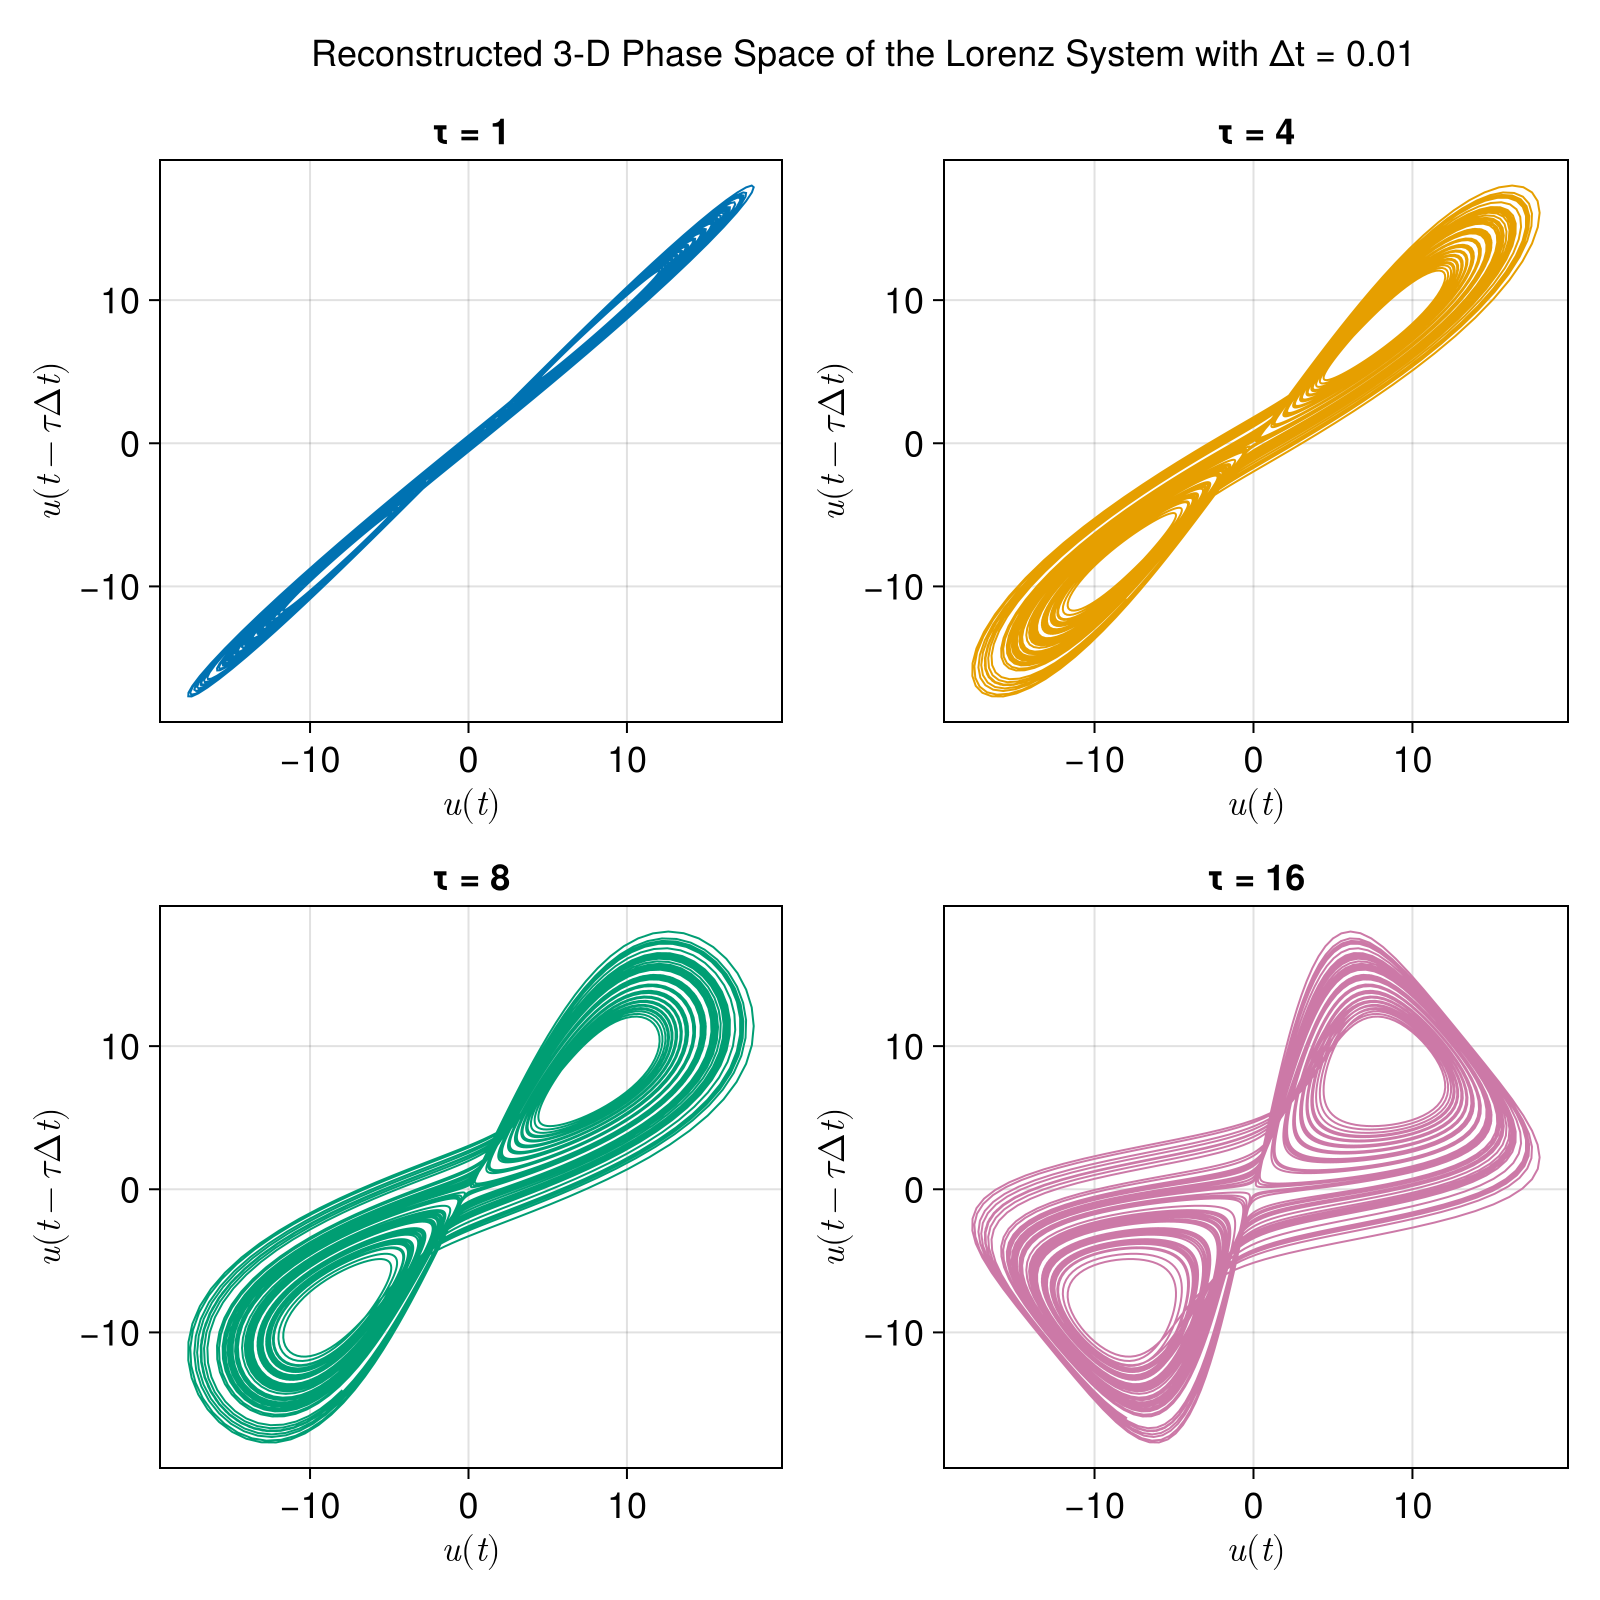

In [7]:
fig = Figure(size = (800, 800), fontsize = 18)
axes = [Axis(fig[1, 1]), Axis(fig[1, 2]), Axis(fig[2, 1]), Axis(fig[2, 2])]

for (i, τ) in enumerate([1, 4, 8, 16])
    data_embedded = embed(s, 3, τ)
    ax = axes[i]
    ax.title = "τ = $τ"
    ax.xlabel = L"u(t)"
    ax.ylabel = L"u(t-\tau \Delta t)"
    lines!(ax, data_embedded[:, 1], data_embedded[:, 2], color = Cycled(i), linewidth=1.0)
end

Label(fig[0, :], "Reconstructed 3-D Phase Space of the Lorenz System with Δt = $Δt")
fig

## 2. Choosing the Optimal Delay Time <a class="anchor" id="time"></a>

- Since no theorem exists guaranteeing an optimal choice of the delay time $\tau$, we must rely instead on a  **prescriptive approach**.
<br>

- As you saw in the first part of the lecture, two possibilities include using the **autocorrelation** and the **self mutual information** of the observed timeseries.
<br>

- Given the lack of an optimal method, it is especially important that we develop an intuitive understanding of the different approaches that are possible.
<br>

- Fortunately, while DynamicalSystems.jl provides useful high-level methods for estimating optimal time delays, it also exposes their low-level counterparts, permitting a more detailed and hands-on analysis.

### 2.1. Autocorrelation

- DynamicalSystems.jl uses the method `autocor` from the [StatsBase.jl](https://juliastats.org/StatsBase.jl/stable/) package for computing autocorrelations.
<br>

- It takes a one-dimensional timeseries as the first argument and an `AbstractVector` of lags as the second argument, returning a `Vector` of autocorrelations, one for each lag provided.

In [8]:
lags = 0:10
autocor(s, lags)

11-element Vector{Float64}:
 1.0
 0.9984384217818205
 0.9938504505857287
 0.9862963457363949
 0.9758747363709581
 0.9627198611247649
 0.9469978943943756
 0.9289025353737472
 0.9086500617201431
 0.8864740600561335
 0.86262004411907

- Let's plot the autocorrelation of our scalar Lorenz timeseries for various different lags.

In [9]:
function plot_autocor(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau",
        xticks = 0:100:500,
        xminorticks = IntervalsBetween(2), 
        xminorticksvisible = true,
        xminorgridvisible = true,
        ylabel = "Autocorrelation", 
    )
    scatter!(ax, autocor(s, lags))
    return fig
end

plot_autocor (generic function with 1 method)

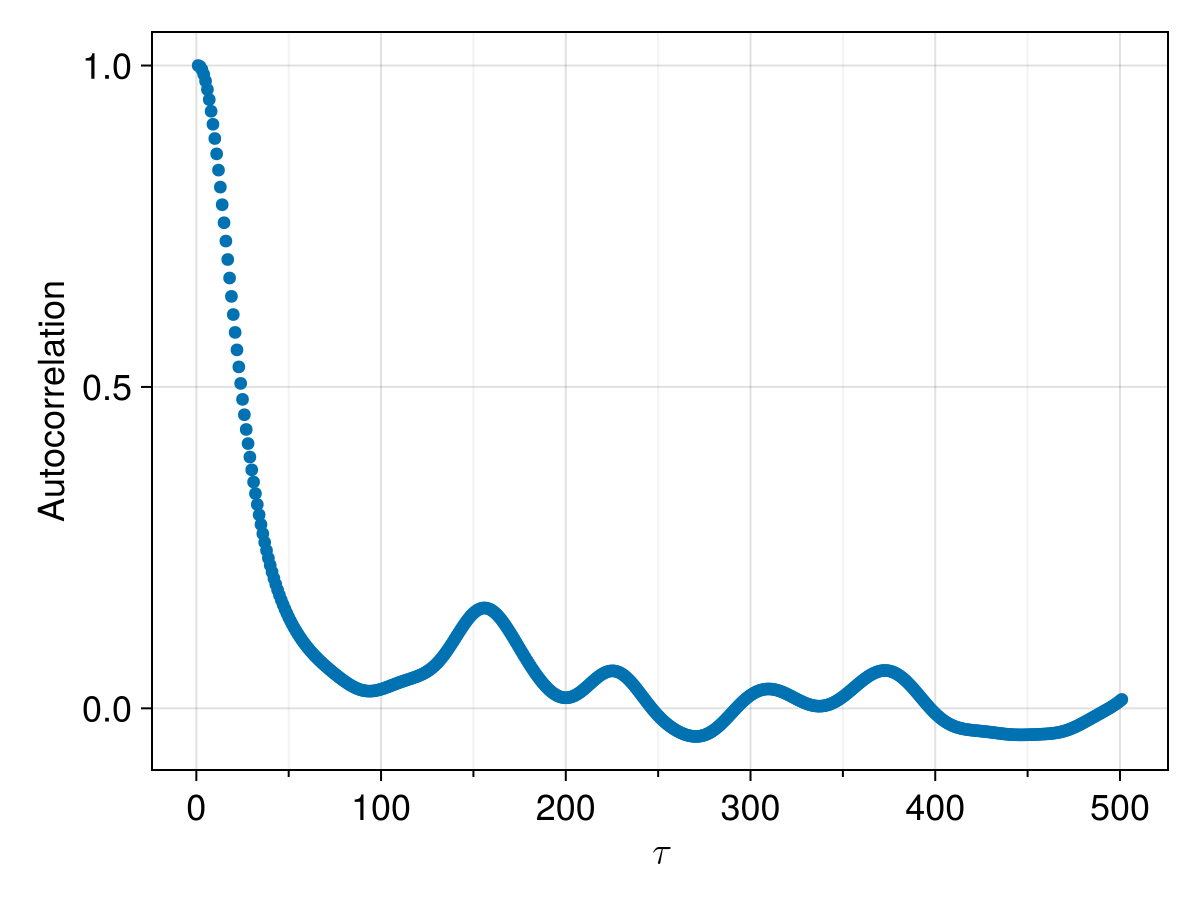

In [10]:
lags = 0:500
plot_autocor(s, lags)

- It looks like the first minimum occurs somewhere around $\tau = 100$, while the zero-crossing time is very long indeed, around $\tau = 275$.
<br>

- Sometimes, especially when embedding in higher dimensions, **relying on the crossing time of the autocorrelation can lead to very long delays**. 
<br>

- Another alternative is to choose as a delay the time taken for the autocorrelation function to decay to $1/e$ of its initial value. DynamicalSystems.jl provides the method `exponential_decay_fit(x, y)` which performs a least squares fit of the form $y = \exp(\frac{x}{\tau})$ and returns $\tau$.

In [11]:
x = 10:40  # You must choose the lags such that the autocorrelation remains positive
y = autocor(s, x)
exponential_decay_fit(x, y)

21.093494781063875

- Based on the autocorrelation, we already have three quite different estimates for the optimal delay, based on the first minimum, zero crossing time, and exponential decay.

### 2.2. Average Mutual Information

- As you learned earlier, a useful and often more robust alternative to autocorrelation is the average mutual information of the timeseries with itself at a given delay.
<br>

- DynamicalSystems.jl implements the method `selfmutualinfo(s, lags)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.selfmutualinfo)).

In [12]:
lags = 0:10
selfmutualinfo(s, lags)

11-element Vector{Float64}:
 4.454498974303407
 3.418701910265987
 2.9332345540222784
 2.6149209421332955
 2.3827865827977743
 2.182439892743087
 2.011666261856478
 1.8701981206924192
 1.761801784152382
 1.6609645338708736
 1.5806987561261086

In [13]:
function plot_selfmutualinfo(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau", 
        xminorticks = IntervalsBetween(5), 
        xminorticksvisible = true,
        xminorgridvisible = true,  
        ylabel = "Self Mutual Information", 
    )
    scatter!(ax, selfmutualinfo(s, lags))
    return fig
end

plot_selfmutualinfo (generic function with 1 method)

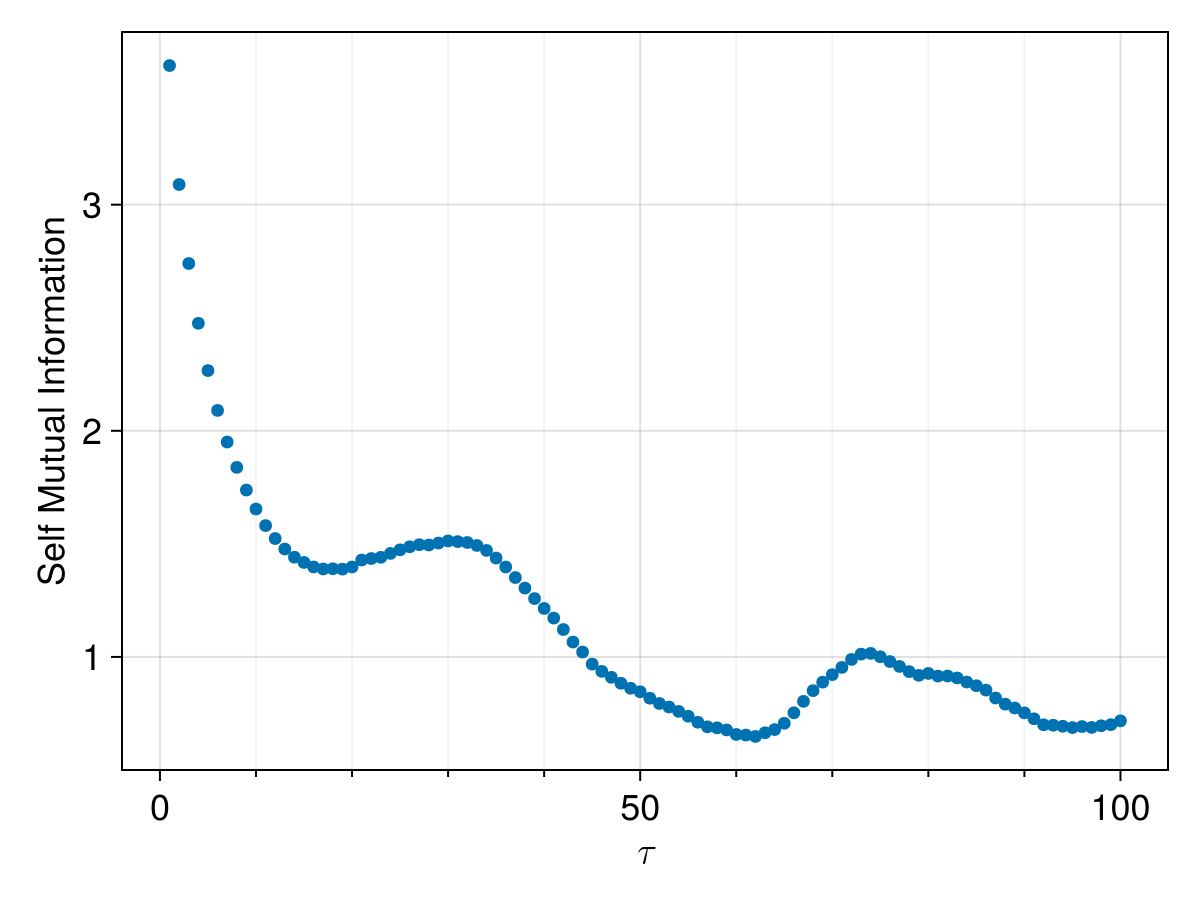

In [14]:
plot_selfmutualinfo(s, 1:100)

- It looks like the first minimum of the self mutual information occurs somewhere around $\tau = 17$, which is fairly similar to our previous estimate using exponential decay of the autocorrelation.

### 2.3. The `estimate_delay` Method

- DynamicalSystems.jl wraps all of these options in the convenient `estimate_delay` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.estimate_delay)).

In [15]:
estimate_delay(s, "ac_min")

93

In [16]:
estimate_delay(s, "ac_zero")

┌ Warning: Did not cross 0 value, returning last `τ`.
└ @ DelayEmbeddings ~/.julia/packages/DelayEmbeddings/YHZpu/src/separated_de/estimate_delay.jl:41


100

In [17]:
estimate_delay(s, "ac_zero", 1:500)

246

In [18]:
estimate_delay(s, "exp_decay")

24

In [19]:
estimate_delay(s, "mi_min")

17

- As you can see, there is quite a range of estimates for $\tau$, emphasising once again the importance of taking a heuristic approach,

## 3. Choosing the Optimal Embedding Dimension <a class="dimension" id="dimension"></a>

- Given an estimate for the time delay, we can proceed to find the embedding dimension using false nearest neighbours.
<br>

- In DynamicalSystems.jl, we can do this using the `delay_fnn` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.delay_fnn)).

In [20]:
?delay_fnn

search: delay_fnn delay_ifnn delay_afnn delay_f1nn



```
delay_fnn(s::AbstractVector, τ:Int, ds = 2:6; rtol=10.0, atol=2.0) → FNNs
```

Calculate the number of "false nearest neighbors" (FNNs) of the datasets created from `s` with `embed(s, d, τ) for d ∈ ds`.

## Description

Given a dataset made by `embed(s, d, τ)` the "false nearest neighbors" (FNN) are the pairs of points that are nearest to each other at dimension `d`, but are separated at dimension `d+1`. Kennel's criteria for detecting FNN are based on a threshold for the relative increment of the distance between the nearest neighbors (`rtol`, eq. 4 in[^Kennel1992]), and another threshold for the ratio between the increased distance and the "size of the attractor" (`atol`, eq. 5 in[^Kennel1992]). These thresholds are given as keyword arguments.

The returned value is a vector with the number of FNN for each `γ ∈ γs`. The optimal value for `γ` is found at the point where the number of FNN approaches zero.

See also: [`optimal_separated_de`](@ref).


In [21]:
function plot_fnn(s, delay, dims)
    fnn = delay_fnn(s, delay, dims)
    
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = "Embedding Dimension",
        ylabel = "False Nearest Neighbours",
    )
    lines!(ax, dims, fnn)
    
    return fnn, fig
end

plot_fnn (generic function with 1 method)

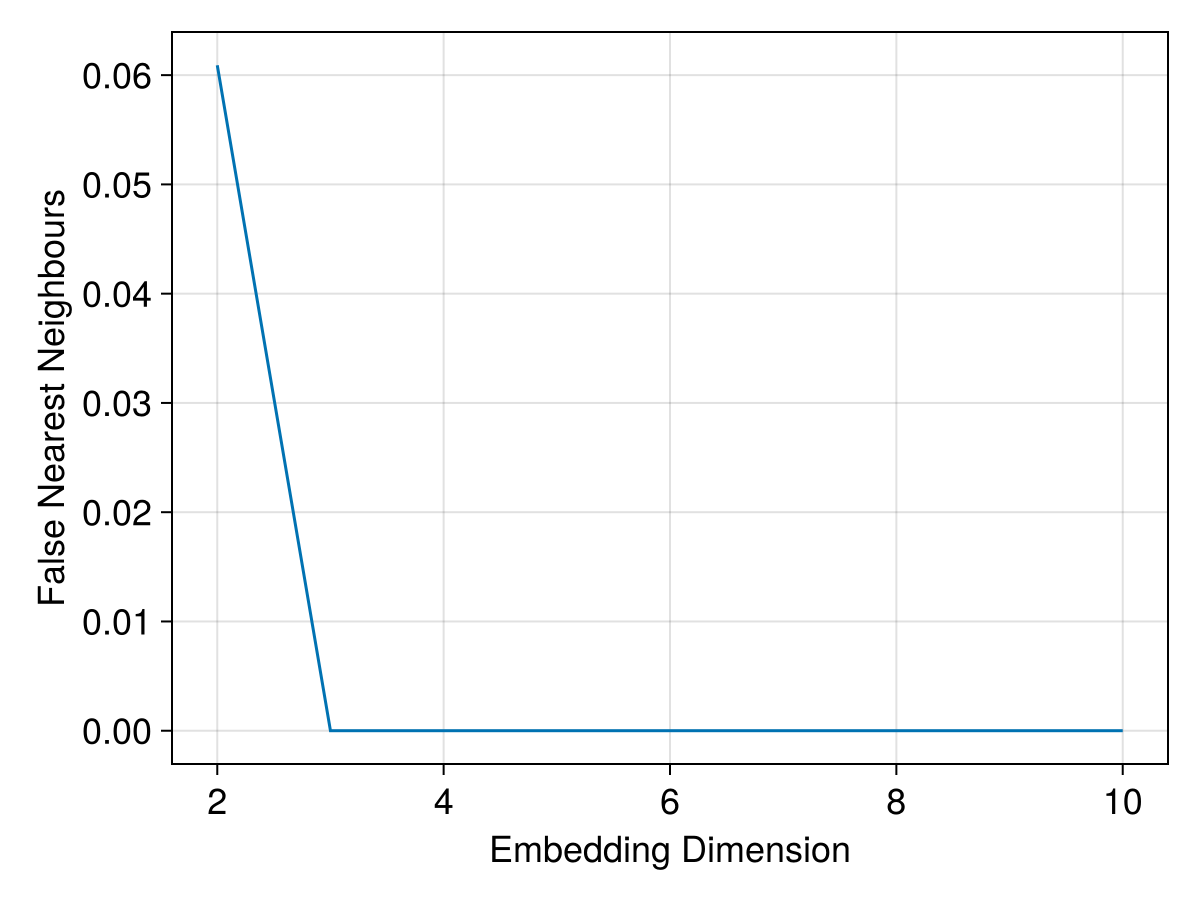

In [23]:
delay = 17
dims = 2:10
fnn, fig = plot_fnn(s, delay, dims)
fig

In [24]:
dims[findfirst(x -> x == 0, fnn)]

3

## 4. Putting It All Together <a class="anchor" id="together"></a>

- If you just want a quick embedding, you can fully automate the procedure outlined in the previous two sections using the method `optimal_separated_de` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.optimal_separated_de)), which returns the embedded timeseries $D$, the delay used $\tau$, and the statistic $E$ used to calculate the optimal embedding dimension.

In [25]:
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 9967 points, 17, [0.0001996679179752374, 0.25744192057555737, 0.9204836714352629, 0.9342964834592663, 0.9552503556059938, 0.9694286474801017, 0.9784168072617306, 0.9836915876823176, 0.9916800400580548, 0.9939154067625753])

- Here, "traditional" means that the algorithm first estimates $\tau$, and then, with $\tau$ fixed, finds the optimal embedding dimension.
<br>

- DynamicalSystems.jl also contains modern "unified" algorithms, which are more sophisticated and jointly optimise the delay and the embedding dimension. See the [docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/unified/) for more details.
<br>

- Given the computational resources we have at our disposal, yet another option is to optimise the embedding with respect to the specific task at hand. For example, if we wish to make timeseries predictions, we could choose the embedding which leads to the most accurate predictions on some validation dataset. 

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

- As you know by now, the maximum Lyapunov exponent of a chaotic system measures the exponential divergence of initially nearby trajectories,

$$|\delta (t)| \approx e^{\lambda t}|\delta (0)|.$$


- Taking the log of both sides and letting $E(t) = \ln|\delta (t)|$,

$$E(t) \approx \lambda \times t + E(0).$$


- Now assume that the timeseries is sampled at equal intervals $\Delta t$ and therefore discretise time by letting $t = k \times Δt$, where $k = 0, 1, 2, \ldots$, such that

$$E(k) \approx \lambda \times k \times Δt + E(0).$$


- Given some dataset, we can now estimate the maximum Lyapunov exponent as the slope of the plot of $E(k)$ versus $k \times Δt$.
<br>

- We can estimate $E(k)$ from the data as follows:

    1. Define neighbourhoods within the data consisting of trajectories which are initially close together (e.g., using nearest neighbours).  

    2. Given those neighbourhoods, step the system forward $k$ steps and take the average of $E(k) = \ln|\delta (k)|$ over all neighbourhoods.  <br><br>
    

- DynamicalSystems.jl makes this easy by providing the methods `lyapunov_from_data` and `linear_region`.

In [26]:
# Generate a longer timeseries than we used before
tr = trajectory(ds, 1000.0; Ttr = 100.0, Δt)[1]
# s = sin.(tr[:, 1])  # Try this for a more challenging observation
s = h(tr);

In [27]:
# Estimate the optimal embedding
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 99967 points, 17, [5.0800848701580105e-5, 0.10307738275327102, 0.9053326344510704, 0.9350778490361434, 0.9587604244650869, 0.9639049864559258, 0.9819768866529327, 0.9872789019063095, 0.9904198973278469, 0.990343216176605])

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/TmOoR/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/TmOoR/src/linear_fits/linear_regions.jl:142


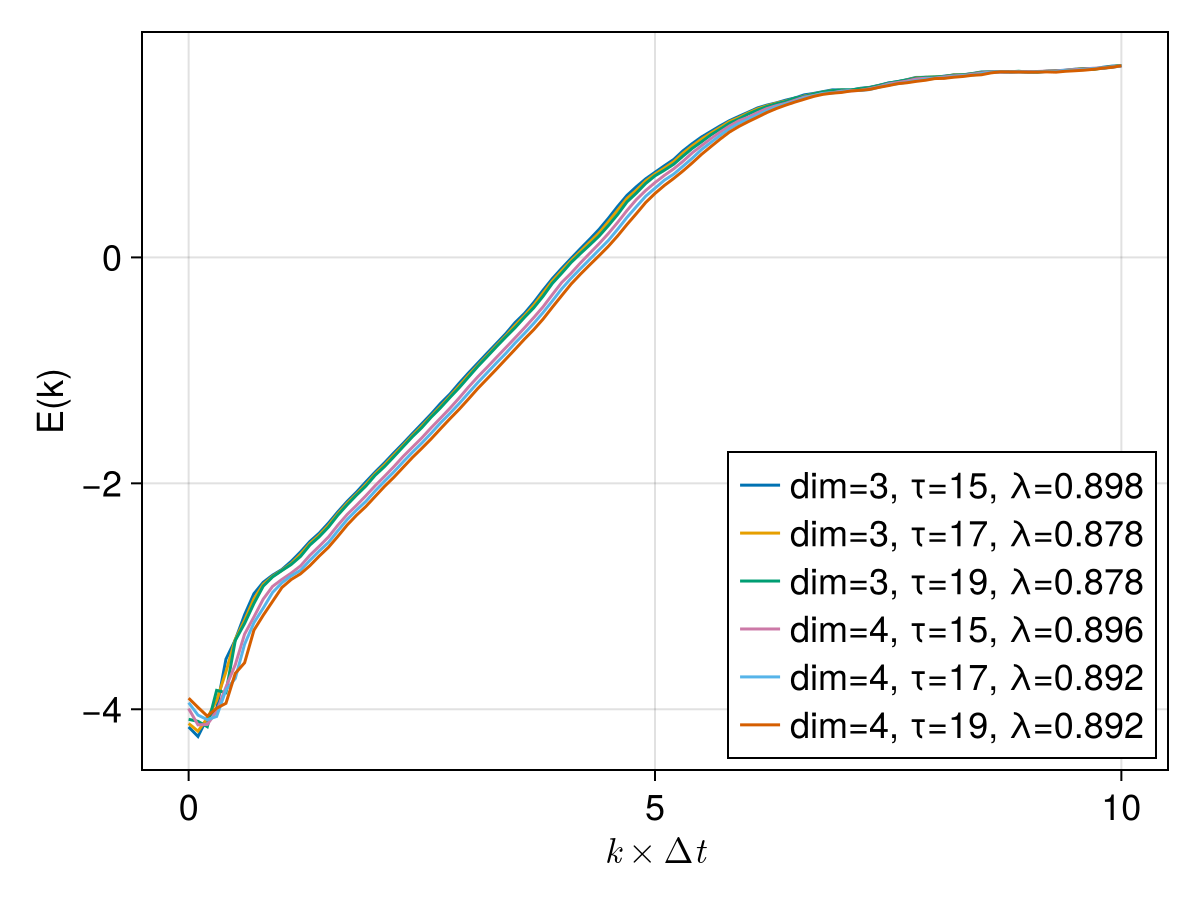

In [28]:
k_values = 0:10:1000  # Integer timesteps k * Δt

fig = Figure(figsize = (500, 500), fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"k \times Δt", ylabel="E(k)")

for dim in [3, 4], τ in [15, 17, 19]  # Try different embedding dimensions and time delays
    data_embedded = embed(s, dim, τ)
    E = lyapunov_from_data(data_embedded, k_values)  # Returns [E(k) for k ∈ k_values]
    λ = linear_region(k_values .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(
        ax, 
        k_values .* Δt, 
        E, 
        label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))",
    )
end

axislegend(ax, position = :rb)
fig

- How do these estimates compare to the true Lyapunov exponent?

In [29]:
lyapunov(ds, 10000.0, Ttr = 100)

0.9055615373287633

- Our estimates for the Lyapunov exponent are not bad at all! In particular, the best estimate corresponds closely to the optimal embedding returned by the `optimal_separated_de` algorithm.
<br>

- This is really quite impressive when we remember that **we started with a one-dimensional observation of the system** and relied on a fully automated identification of the optimal embedding.
<br>

- This confirms our claim that we can reconstruct an attractor based only on a one-dimensional time series.

## 6. Forecasts with Time Delay Embeddings <a class="anchor" id="forecasts"></a>

- One application of time-delay embedding is to use the embedding for forecasts.
<br><br>
- Here, we demonstrate a very simple model based on time-delay embedding.
<br><br>
- In this first example, we generate data from a Lorenz system and only take the first dimension ($x$) as training data. 
<br><br>
- In the exercise you will apply this to real temperature data.

First, we generate the Lorenz data and plot it, we'll only save the first, the x dimension, and pretend to forget about the other two variables.

In [31]:
ds = Systems.lorenz()
tr = trajectory(ds, 1000, Ttr=100.0)
data = tr[1][:,1]; # just save the x variable 

Then, we perform a time delay embedding.

In [33]:
D, τ, E = optimal_separated_de(data)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(4-dimensional StateSpaceSet{Float64} with 9995 points, 2, [0.0002766388300858012, 0.14983162128322905, 0.8458127674423592, 0.9189064924261073, 0.9438479750337145, 0.9809962433402144, 0.9856636674441384, 0.9826645044088999, 0.9843546214514439, 0.9923338798832373])

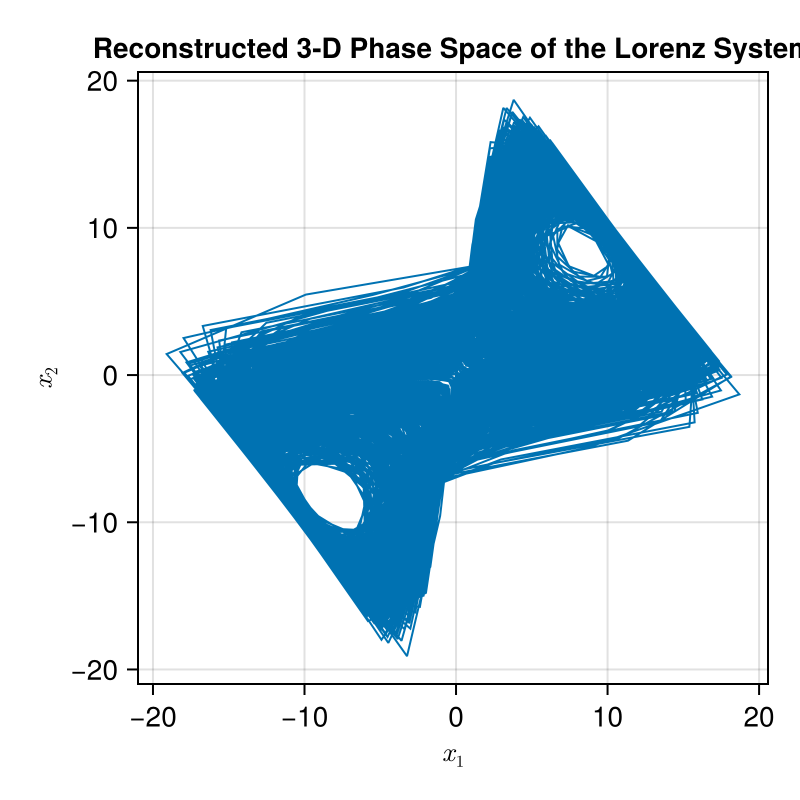

In [36]:
fig = Figure(size = (400, 400), fontsize = 14)
ax = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title =  "Reconstructed 3-D Phase Space of the Lorenz System")

lines!(ax, D[:, 1], D[:, 2], color = Cycled(1), linewidth=1.0)
fig

### Time Series Prediction with Delay Embeddings 

- We can use the reconstructed dynamics to make forecasts.
<br><br>
- The basic idea is the following: a point in the high-dimensional (fully embedded / unfolded) phase space will evolve similarly to its neighbours in phase space. 
<br><br>
- We can set up a simple version of a model using this idea as follows: 
<br><br>
    * Consider a point $\vec{v}(n)$ in phase space, where $n$ denotes the time index.
    <br><br>
    * Denote by $\vec{v}^{(r)}(n)$ its $r$-th nearest neighbour, with $r=1,2,..,N$.
    <br><br>
    * Our ansatz is a local linear model that predicts the next point as $\vec{v}(n+1) = \mathbf{a} + \mathbf{B}\cdot\vec{v}(n)$.
    <br><br>
    * The coefficients are determined by a least squares fit at every point in the neighbourhood dataset that minimizes
    <br><br>
    $$\sum_{r=0}^{N} \left|\vec{v}^{(r)}(n+1) - \mathbf{a} - \mathbf{B}\cdot\vec{v}^{(r)}(n)\right|^2,$$
    where $\vec{v}^{(0)}(n)$ = $\vec{v}(n)$.
    <br><br>
    * We can do this minimization with a linear regression (`\` operator in Julia).
    <br><br>
    * If we then want to forecast one step ahead from a new point $\vec{z}(n)$, we look up the coefficients $ \mathbf{a}_{NN}$ and $\mathbf{B}_{NN}$ of its neareast neighbour and predict its evolution with 
    <br><br>
    $$\vec{z}(n+1) = \mathbf{a}_{NN} + \mathbf{B}_{NN} \cdot \vec{z}(n)$$
* For longer predictions, we can apply this procedure recursively.

In [37]:
struct LocalTDEPrediction{T,S,U}
    A::T     # regression coefficients 
    B::T     # regression coefficients 
    N::S     # amount of neighbours 
    tree::U  # neighbourhood tree
end 

"""
    LocalTDEPrediction(data, N::Integer)

Sets up a local linear prediction model, based on a time delay embedding `data`. 
`data` is expected to be `N_t x N_dim`
The prediction is based on the dynamics a local model of `N` neighbours in phase
space
"""
function LocalTDEPrediction(data, N::Integer)
    neighbour_tree = KDTree(transpose(data[1:end-1,:]))  # KDTree is expected it in N_dim x N_points format
    N_d = size(data, 2)
        
    A = zeros(size(data,1)-1, N_d)
    B = zeros(size(data,1)-1, N_d) 
    
    # Loop over the points in the dataset
    for i_point = 1:(size(data,1)-1)
        NN_inds, dists = knn(neighbour_tree, data[i_point,:], N)  # returns the N nearest neighbours

        # Loop over each dimension
        for i = 1:N_d 
            coeffs = hcat(ones(N), data[NN_inds,i]) \ data[NN_inds.+1,i]  # linear regression, seperately for each dimension 
            # we could improve it with a proper MLR
    
            A[i_point, i] = coeffs[1]
            B[i_point, i] = coeffs[2]
        end
    end
    return LocalTDEPrediction(A, B, N, neighbour_tree)
end

LocalTDEPrediction

In [38]:
"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T})

Predict the system one step ahead from state `ic`. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}) where T
    inds, dists = knn(pred.tree, ic, 1)  # first the closest point 
    ind = inds[1]
    return pred.A[ind,:] .+ pred.B[ind,:] .* ic
end

"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer)

Recursively uses a one step ahead prediction to predict the system for `N` steps. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer) where T
    result = zeros(T, length(ic), N+1)
    result[:,1] = ic
    
    for i=2:N+1 
        result[:,i] = predict(pred, result[:,i-1])
    end 
    
    return result
end 

predict

- We split the data into a training and validation set and setup the prediction model.

In [39]:
D = Matrix(D)  # we have to convert D to a regular array before 

N_train = Int(floor(0.8 * size(D,1)))

D_train = D[1:N_train,:]
D_valid = D[N_train+1:end,:]

pred = LocalTDEPrediction(D_train, 10)

LocalTDEPrediction{Matrix{Float64}, Int64, KDTree{SVector{4, Float64}, Euclidean, Float64}}([-10.830182630282406 2.371313478230877 1.6295597815585243 3.2262808492626203; -47.115240996932066 1.3495989763119363 1.2657058412427928 17.4602099745277; … ; 0.23137741124196365 21.51742237141855 0.28026376708903095 0.7940690589268606; 10.23424117784269 -1.2183492290841889 -0.38343264319893977 3.913066183170206], [0.5721761155976646 0.4448261672148185 1.301484652332199 1.165933905502866; -2.2072127398218377 0.06505076118670523 1.3553088452305515 -0.421774782345876; … ; 1.6151865403287773 -0.8801984130888788 0.5656687372140631 1.4008754546505306; 0.28085089290067383 0.643492818078936 1.2132312040557687 1.0750600186407935], 10, KDTree{SVector{4, Float64}, Euclidean, Float64}
  Number of points: 7995
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true)

- Then, we apply the prediction.

In [40]:
N_predict = 100
prediction_result = predict(pred, D_valid[1,:], N_predict);
truth = D_valid[1:N_predict+1,:];

- We try to predict the first dimension, as this is also our observable:

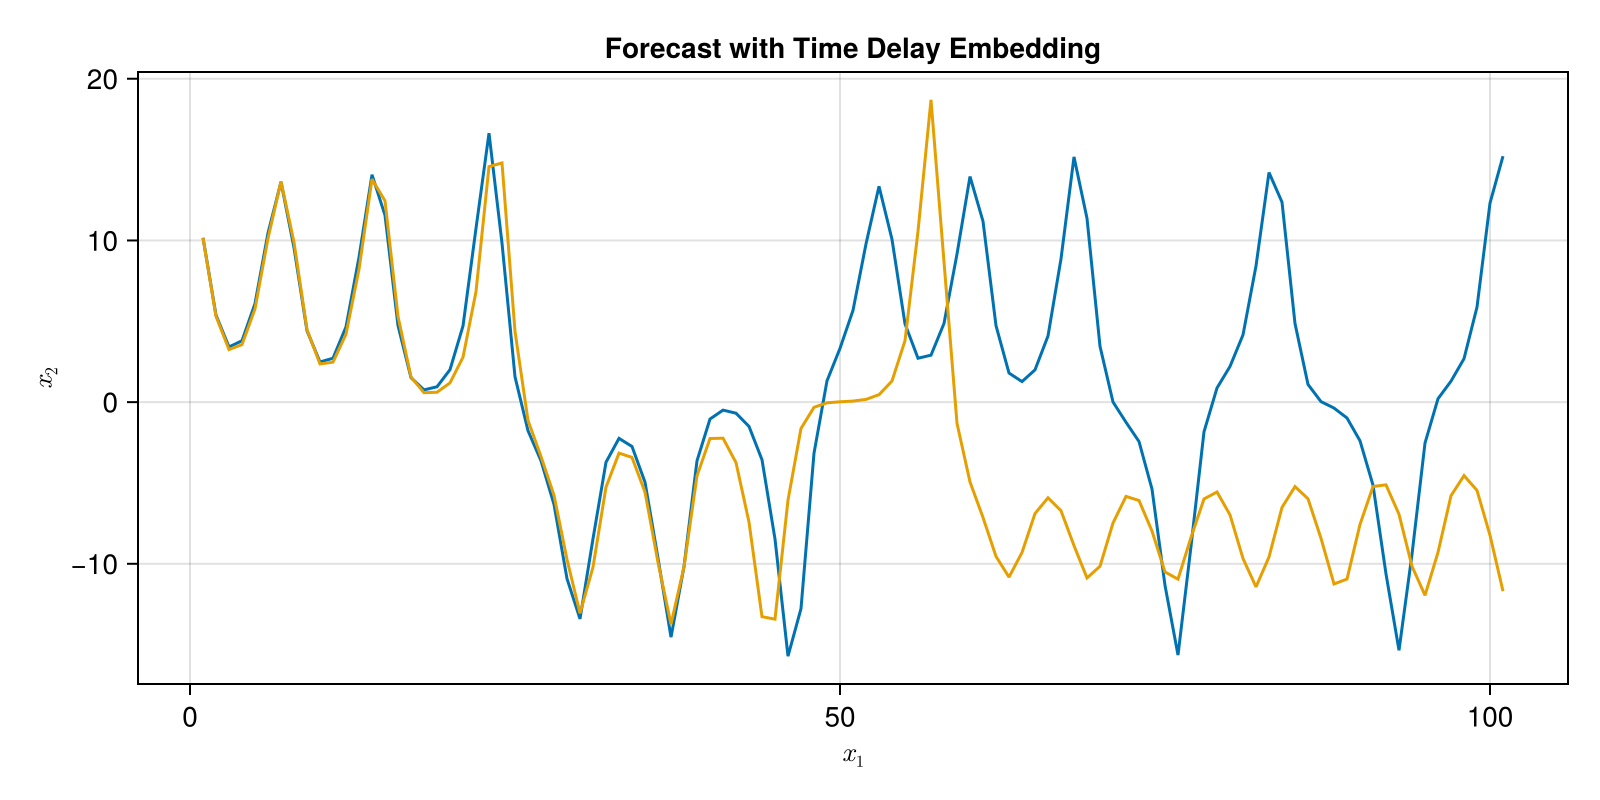

In [41]:
fig = Figure(size = (800, 400), fontsize = 14)
ax = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title =  "Forecast with Time Delay Embedding")

lines!(ax, prediction_result[1,:], label="x - prediction")
lines!(ax, truth[:,1], label="Observable")

fig 

- We could improve this method with more sophisticated local models than just the linear regression. But already like this, we get decent results for the Lorenz system. Remember, due to the chaotic nature of the Lorenz system even the smalles deviations will grow exponentially, so that forecast lengths will always be limited 

## 7. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/dev/)
2. [DelayEmbeddings.jl documentation](https://juliadynamics.github.io/DelayEmbeddings.jl/dev/)
3. [Nonlinear Time Series Analysis (Kantz & Schreiber 2003)](https://www.cambridge.org/core/books/nonlinear-time-series-analysis/519783E4E8A2C3DCD4641E42765309C7)
4. [Analysis of Observed Chaotic Data (Abarbanel 1996)](https://link.springer.com/book/10.1007/978-1-4612-0763-4)